In [2]:
%pip install scipy
%pip install matplotlib
%pip install pandas
%pip install sippy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

  Using cached sippy-2.2.0-py3-none-any.whl
  Using cached elperiodic-1.4.tar.gz (14 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pycryptodome-3.21.0-cp36-abi3-win_amd64.whl.metadata (3.4 kB)
  Using cached websockets-14.1-cp313-cp313-win_amd64.whl.metadata (6.9 kB)
Using cached pycryptodome-3.21.0-cp36-abi3-win_amd64.whl (1.8 MB)
Using cached websockets-14.1-cp313-cp313-win_amd64.whl (163 kB)
Failed to build ElPeriodic
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for ElPeriodic (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [9 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-313\elperiodic
      copying python\ElPeriodic.py -> build\lib.win-amd64-cpython-313\elperiodic
      copying python\__init__.py -> build\lib.win-amd64-cpython-313\elperiodic
      running build_ext
      building '_elperiodic' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for ElPeriodic
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (ElPeriodic)


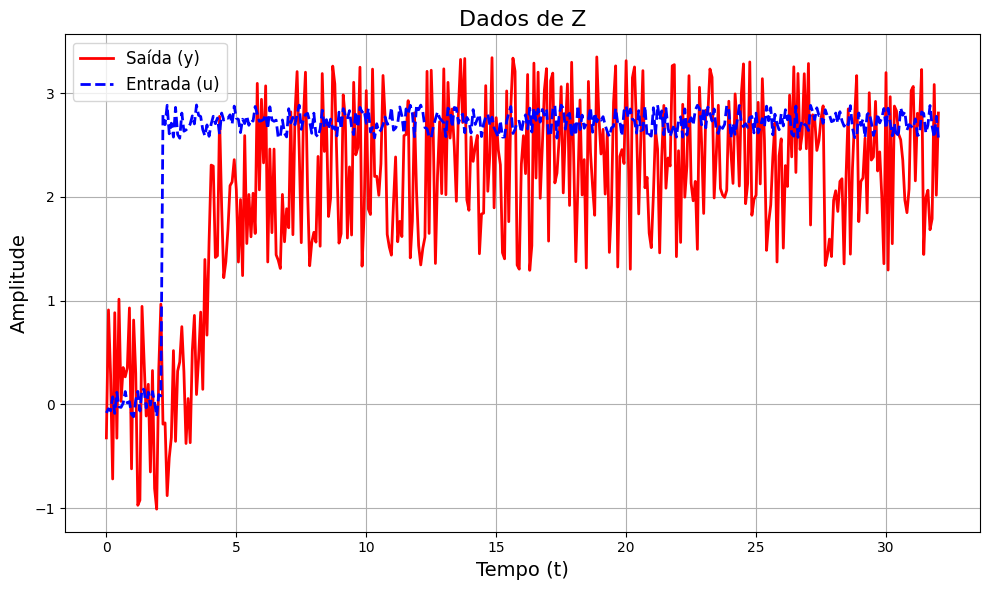

In [3]:
import scipy.io
import matplotlib.pyplot as plt

# Carregar os dados do arquivo .mat
data = scipy.io.loadmat('dados.mat')  # Substitua pelo nome do arquivo correto
Z = data['Z']  # Ajuste a chave se necessário

# Separar as colunas de Z
t = Z[:, 0]  # Supondo que a primeira coluna seja o tempo
u = Z[:, 1]  # Segunda coluna como entrada
y = Z[:, 2]  # Terceira coluna como saída

# Plotar os dados
plt.figure(figsize=(10, 6))

# Plotar a saída y
plt.plot(t, y, label='Saída (y)', color='red', linestyle='-', linewidth=2)

# Plotar a entrada u
plt.plot(t, u, label='Entrada (u)', color='blue', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.title('Dados de Z', fontsize=16)
plt.xlabel('Tempo (t)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Salvar e exibir o gráfico
plt.savefig("assets/Z.png")
plt.show()


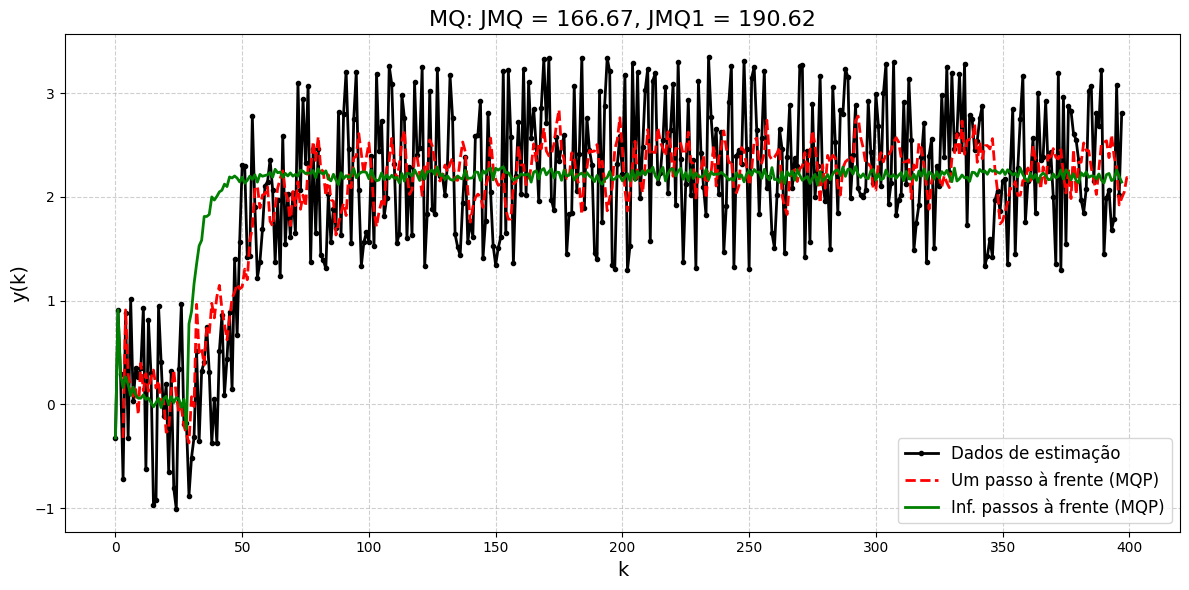

In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Carregar o arquivo .mat
data = scipy.io.loadmat('dados.mat')
Z = data['Z']

# Extrair y e u das colunas apropriadas
u = Z[:, 1]  
y = Z[:, 2] 

# Verificar tamanho mínimo
if len(y) < 4 or len(u) < 3:
    raise ValueError("Os vetores y e u precisam ter pelo menos 4 e 3 elementos, respectivamente.")

# Construção da matriz Psi e do vetor de saída y1
Psi = np.column_stack([y[:-3], y[1:-2], y[2:-1], u[1:-2], u[2:-1]])
y1 = y[3:]

# Estimativa dos parâmetros (tetaChapeu)
tetaChapeu = np.linalg.pinv(Psi.T @ Psi) @ (Psi.T @ y1)

# Estimação de yChapeu
yChapeu = y.copy()
yChapeu[3:] = Psi @ tetaChapeu
csiMQ = y - yChapeu
JMQ = csiMQ.T @ csiMQ

# Estimação de yChapeu1 (infinitos passos à frente)
yChapeu1 = y.copy()
for i in range(3, len(yChapeu1)):
    yChapeu1[i] = (
        tetaChapeu[0] * yChapeu1[i-3] +
        tetaChapeu[1] * yChapeu1[i-2] +
        tetaChapeu[2] * yChapeu1[i-1] +
        tetaChapeu[3] * u[i-2] +
        tetaChapeu[4] * u[i-1]
    )

csiMQ1 = y - yChapeu1
JMQ1 = csiMQ1.T @ csiMQ1

# Plot dos resultados
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y)), y, 'k.-', linewidth=2, markersize=6, label='Dados de estimação')
plt.plot(np.arange(3, len(yChapeu) + 3), yChapeu, 'r--', linewidth=2, label='Um passo à frente (MQP)')
plt.plot(np.arange(len(yChapeu1)), yChapeu1, 'g-', linewidth=2, label='Inf. passos à frente (MQP)')

# Configuração do gráfico
plt.title(f'MQ: JMQ = {JMQ:.2f}, JMQ1 = {JMQ1:.2f}', fontsize=16)
plt.xlabel('k', fontsize=14)
plt.ylabel('y(k)', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Salvar e exibir o gráfico
plt.savefig("assets/mq.png", dpi=300)
plt.show()



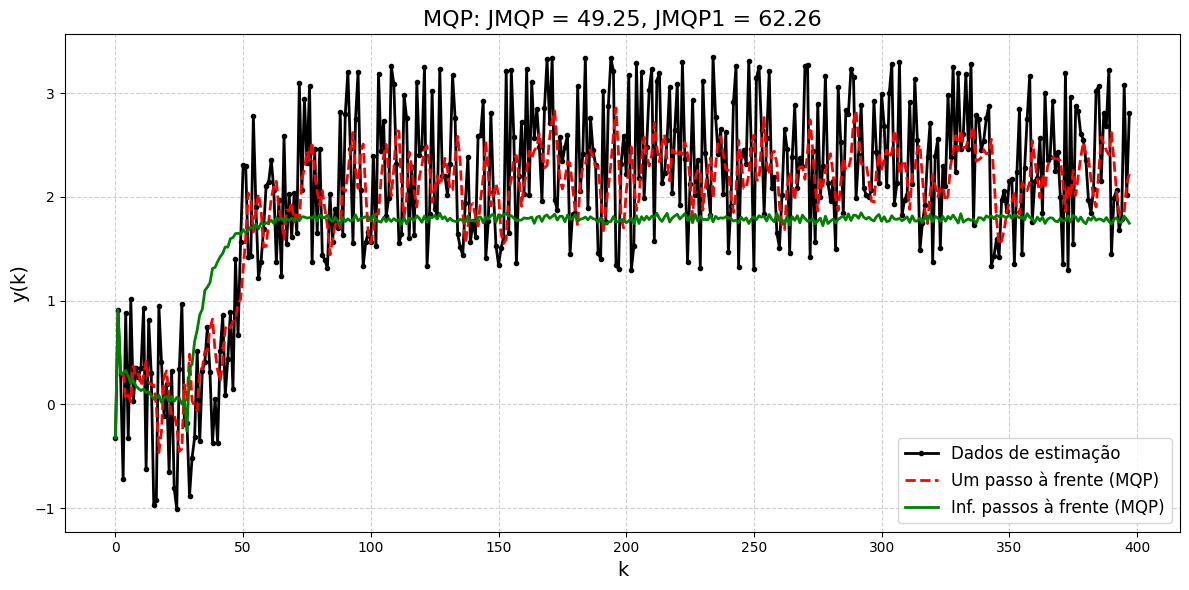

In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Carregar o arquivo .mat
data = scipy.io.loadmat('dados.mat')
Z = data['Z']

# Extrair y e u das colunas apropriadas
u = Z[:, 1]  
y = Z[:, 2]  

# Construção da matriz Psi e do vetor y1
Psi = np.column_stack([y[:-3], y[1:-2], y[2:-1], u[1:-2], u[2:-1]])
y1 = y[3:]

# Definição dos pesos para MQP
w1 = 1
n1 = 100
w2 = 0.05
n2 = len(y1) - n1
W = np.diag([w1] * n1 + [w2] * n2)  # Matriz diagonal de pesos

# Estimativa dos parâmetros (MQP)
tetaChapeu = np.linalg.pinv(Psi.T @ W @ Psi) @ (Psi.T @ W @ y1)

# Estimação de yChapeu (dados de estimação)
yChapeu = Psi @ tetaChapeu
csiMQP = y1 - yChapeu  # Resíduos ponderados
JMQP = csiMQP.T @ W @ csiMQP  # Função de custo ponderada

# Estimação de yChapeu1 (infinitos passos à frente)
yChapeu1 = y.copy()
for i in range(3, len(yChapeu1)):
    yChapeu1[i] = (
        tetaChapeu[0] * yChapeu1[i-3] +
        tetaChapeu[1] * yChapeu1[i-2] +
        tetaChapeu[2] * yChapeu1[i-1] +
        tetaChapeu[3] * u[i-2] +
        tetaChapeu[4] * u[i-1]
    )

# Cálculo dos resíduos e função de custo para yChapeu1
csiMQP1 = y1 - yChapeu1[3:]
JMQP1 = csiMQP1.T @ W @ csiMQP1

# Plot dos resultados
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y)), y, 'k.-', linewidth=2, markersize=6, label='Dados de estimação')
plt.plot(np.arange(3, len(yChapeu) + 3), yChapeu, 'r--', linewidth=2, label='Um passo à frente (MQP)')
plt.plot(np.arange(len(yChapeu1)), yChapeu1, 'g-', linewidth=2, label='Inf. passos à frente (MQP)')

# Configuração do gráfico
plt.title(f'MQP: JMQP = {JMQP:.2f}, JMQP1 = {JMQP1:.2f}', fontsize=16)
plt.xlabel('k', fontsize=14)
plt.ylabel('y(k)', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Salvar e exibir o gráfico
plt.savefig("assets/mqp.png", dpi=300)
plt.show()


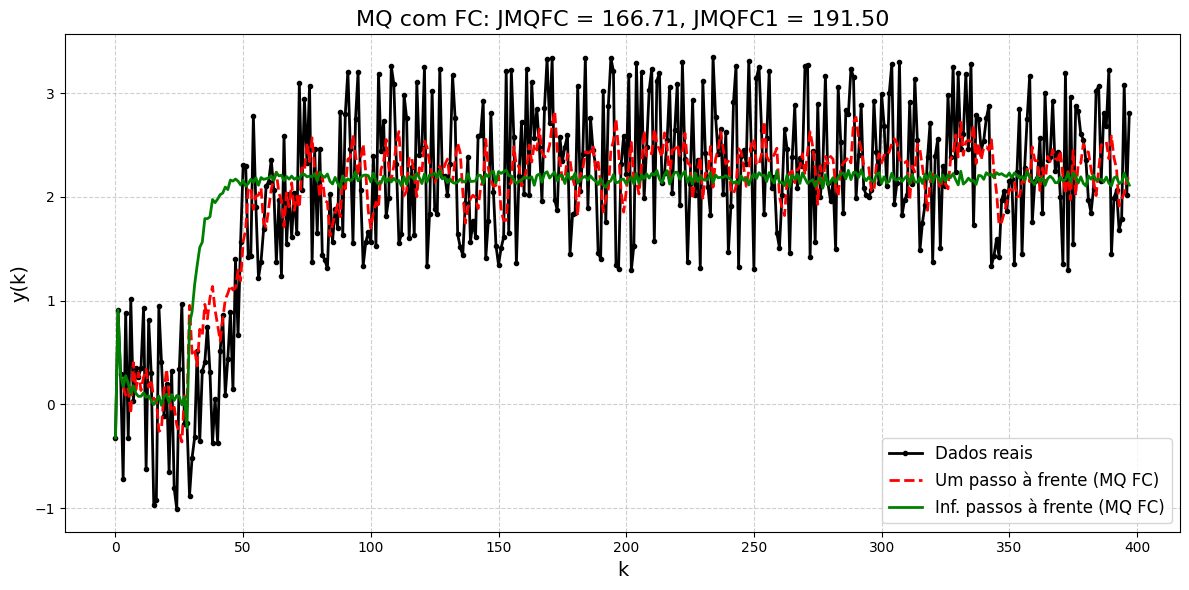

In [6]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados
data = scipy.io.loadmat('dados.mat')
Z = data['Z']

# Extrair y e u das colunas apropriadas
u = Z[:, 1]  
y = Z[:, 2]  

# Centralizar os dados
um = u - np.mean(u)  # Centralizar a entrada
ym = y - np.mean(y)  # Centralizar a saída

# Construção da matriz Psim
Psim = np.column_stack([
    ym[:-3], ym[1:-2], ym[2:-1],
    um[1:-2], um[2:-1]
])

# Cálculo de Ruu e ruy
Ruu = np.zeros((5, 5))
ruy = np.zeros((5, 1))

for i in range(5):
    ruy[i, 0] = Psim[:, i].T @ ym[3:]
    for j in range(5):
        Ruu[i, j] = Psim[:, i].T @ Psim[:, j]

# Estimativa dos parâmetros (tetaChapeu)
tetaChapeu = np.linalg.solve(Ruu, ruy)

# Estimação de yChapeu (dados de estimação)
yChapeu = y.copy()
yChapeu[3:] = (Psim @ tetaChapeu).flatten() + np.mean(y)

# Cálculo de resíduos e função de custo
csiMQFC = y - yChapeu
JMQFC = csiMQFC.T @ csiMQFC

# Estimação de yChapeu1 (infinitos passos à frente)
yChapeu1 = ym.copy()
for i in range(3, len(yChapeu1)):
    tetaChapeu = tetaChapeu.flatten()
    yChapeu1[i] = (
        tetaChapeu[0] * yChapeu1[i-3] +
        tetaChapeu[1] * yChapeu1[i-2] +
        tetaChapeu[2] * yChapeu1[i-1] +
        tetaChapeu[3] * um[i-2] +
        tetaChapeu[4] * um[i-1]
    )

yChapeu1 = yChapeu1 + np.mean(y)

# Cálculo de resíduos e função de custo para infinitos passos à frente
csiMQFC1 = y - yChapeu1
JMQFC1 = csiMQFC1.T @ csiMQFC1

# Plot dos resultados
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y)), y, 'k.-', linewidth=2, markersize=6, label='Dados reais')
plt.plot(np.arange(3, len(y)), yChapeu[3:], 'r--', linewidth=2, label='Um passo à frente (MQ FC)')
plt.plot(np.arange(len(yChapeu1)), yChapeu1, 'g-', linewidth=2, label='Inf. passos à frente (MQ FC)')

# Configuração do gráfico
plt.title(f'MQ com FC: JMQFC = {JMQFC:.2f}, JMQFC1 = {JMQFC1:.2f}', fontsize=16)
plt.xlabel('k', fontsize=14)
plt.ylabel('y(k)', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Salvar e exibir o gráfico
plt.savefig("assets/mq_fc.png", dpi=300)
plt.show()


Melhor modelo ARX: na=5, nb=5, JMQ=147.7589


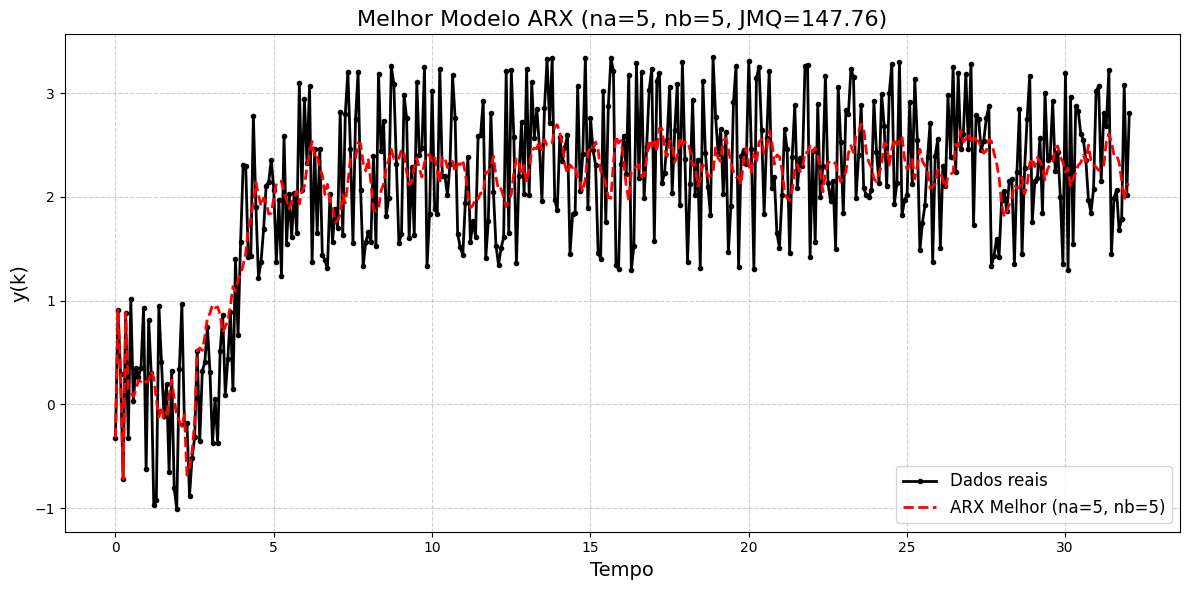

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import lstsq

# Carregar os dados
data = loadmat('dados.mat')
Z = data['Z']

# Extrair tempo, entrada (u) e saída (y)
t = Z[:, 0]  # Coluna 0 é o tempo
u = Z[:, 1]  # Coluna 1 é a entrada
y = Z[:, 2]  # Coluna 2 é a saída

# Configurações do modelo ARX
max_na = 5  # Ordem máxima de A(q)
max_nb = 5  # Ordem máxima de B(q)
nk = 1  # Atraso inicial

# Inicializar matrizes de erro e função de custo
JMQarx = np.zeros((max_na, max_nb))

# Variáveis para armazenar o melhor modelo
best_na = None
best_nb = None
best_theta = None
best_yarx = None
best_JMQ = float('inf')

# Função auxiliar para o modelo ARX
def arx_model(y, u, na, nb, nk):
    """Estima os coeficientes de um modelo ARX e retorna y_hat e coeficientes."""
    n = len(y)
    max_delay = max(na, nb + nk - 1)
    Phi = []
    for i in range(max_delay, n):
        row = []
        # Termos autoregressivos da saída y (A(q))
        row.extend(-y[i - j - 1] for j in range(na))
        # Termos regressivos da entrada u (B(q))
        row.extend(u[i - j - nk] for j in range(nb))
        Phi.append(row)
    Phi = np.array(Phi)
    y_target = y[max_delay:]

    # Estimativa dos parâmetros via mínimos quadrados
    theta, _, _, _ = lstsq(Phi, y_target)

    # Recriar a saída estimada
    y_hat = np.zeros(n)
    y_hat[:max_delay] = y[:max_delay]
    for i in range(max_delay, n):
        y_hat[i] = np.dot(Phi[i - max_delay], theta)
    return y_hat, theta

# Loop para varrer valores de na e nb
for na in range(1, max_na + 1):
    for nb in range(1, max_nb + 1):
        yarx, theta = arx_model(y, u, na, nb, nk)
        JMQ = np.sum((y - yarx) ** 2)
        JMQarx[na - 1, nb - 1] = JMQ

        # Verificar se este é o melhor modelo
        if JMQ < best_JMQ:
            best_na = na
            best_nb = nb
            best_theta = theta
            best_yarx = yarx
            best_JMQ = JMQ

# Resultados do melhor modelo
print(f"Melhor modelo ARX: na={best_na}, nb={best_nb}, JMQ={best_JMQ:.4f}")

# Plot do melhor modelo
plt.figure(figsize=(12, 6))
plt.plot(t, y, 'k.-', linewidth=2, markersize=6, label='Dados reais')
plt.plot(t, best_yarx, 'r--', linewidth=2, label=f'ARX Melhor (na={best_na}, nb={best_nb})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('y(k)', fontsize=14)
plt.title(f'Melhor Modelo ARX (na={best_na}, nb={best_nb}, JMQ={best_JMQ:.2f})', fontsize=16)
plt.tight_layout()
plt.savefig("assets/best_arx_model.png", dpi=300)
plt.show()

Melhor modelo ARMAX: na=5, nb=1, nc=5, JMQ=150.2914


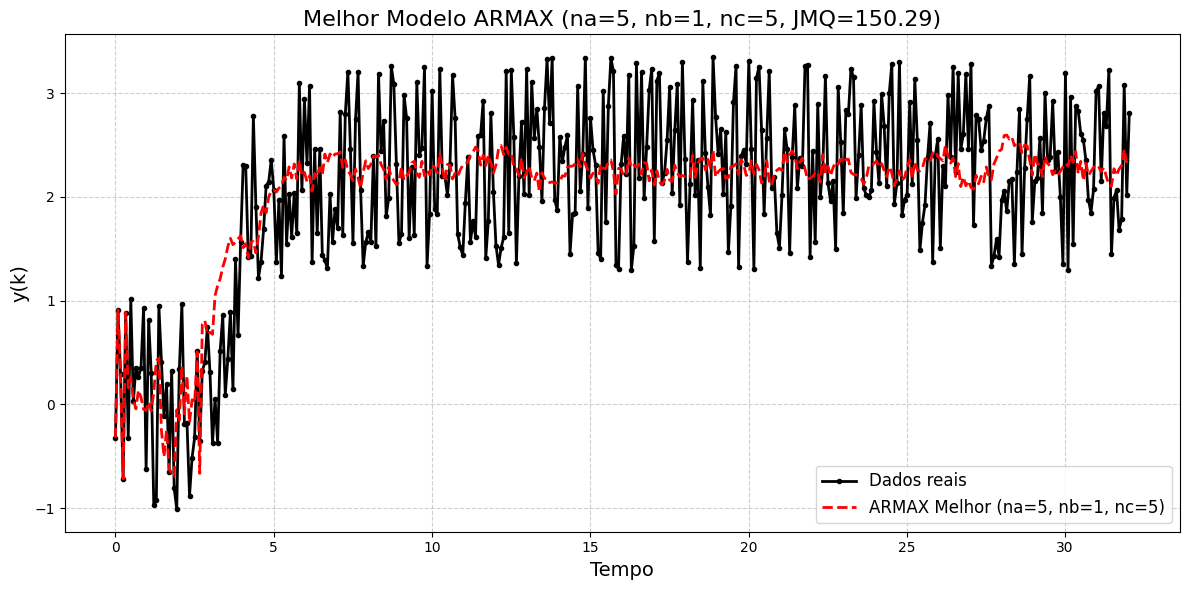

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

# Carregar os dados
data = loadmat('dados.mat')
Z = data['Z']

# Extrair tempo, entrada (u) e saída (y)
t = Z[:, 0]  # Coluna 0 é o tempo
u = Z[:, 1]  # Coluna 1 é a entrada
y = Z[:, 2]  # Coluna 2 é a saída

# Configurações do modelo ARMAX
max_na = 5  # Ordem máxima de A(q)
max_nb = 5  # Ordem máxima de B(q)
max_nc = 5  # Ordem máxima de C(q)
nk = 1  # Atraso inicial

# Inicializar matrizes de erro e função de custo
JMQarmax = np.zeros((max_na, max_nb, max_nc))

# Variáveis para armazenar o melhor modelo
best_na = None
best_nb = None
best_nc = None
best_theta = None
best_yarmax = None
best_JMQ = float('inf')

# Função auxiliar para o modelo ARMAX
def armax_model(y, u, na, nb, nc, nk):
    """Estima os coeficientes de um modelo ARMAX e retorna y_hat e coeficientes."""
    n = len(y)
    max_delay = max(na, nb + nk - 1, nc)
    Phi = []
    e_prev = np.zeros(n)  # Inicializar o vetor de resíduos
    for i in range(max_delay, n):
        row = []
        # Termos autoregressivos da saída y (A(q))
        row.extend(-y[i - j - 1] for j in range(na))
        # Termos regressivos da entrada u (B(q))
        row.extend(u[i - j - nk] for j in range(nb))
        # Termos do ruído (C(q)), usando resíduos anteriores
        row.extend(e_prev[i - j - 1] for j in range(nc))
        Phi.append(row)

        # Atualizar o resíduo após a construção da linha
        if len(Phi) > 1:
            e_prev[i] = y[i] - np.dot(Phi[-1], lstsq(Phi[:-1], y[max_delay:i])[0])
    Phi = np.array(Phi)
    y_target = y[max_delay:]

    # Estimativa dos parâmetros via mínimos quadrados
    theta, _, _, _ = lstsq(Phi, y_target)

    # Recriar a saída estimada
    y_hat = np.zeros(n)
    y_hat[:max_delay] = y[:max_delay]
    for i in range(max_delay, n):
        for j in range(na):
            y_hat[i] -= theta[j] * y_hat[i - j - 1]  # A(q)
        for j in range(nb):
            y_hat[i] += theta[na + j] * u[i - j - nk]  # B(q)
        for j in range(nc):
            y_hat[i] += theta[na + nb + j] * e_prev[i - j - 1]  # C(q)
    return y_hat, theta

# Loop para varrer valores de na, nb e nc
for na in range(1, max_na + 1):
    for nb in range(1, max_nb + 1):
        for nc in range(1, max_nc + 1):
            yarmax, theta = armax_model(y, u, na, nb, nc, nk)
            JMQ = np.sum((y - yarmax) ** 2)
            JMQarmax[na - 1, nb - 1, nc - 1] = JMQ

            # Verificar se este é o melhor modelo
            if JMQ < best_JMQ:
                best_na = na
                best_nb = nb
                best_nc = nc
                best_theta = theta
                best_yarmax = yarmax
                best_JMQ = JMQ

# Resultados do melhor modelo
print(f"Melhor modelo ARMAX: na={best_na}, nb={best_nb}, nc={best_nc}, JMQ={best_JMQ:.4f}")

# Plot do melhor modelo
plt.figure(figsize=(12, 6))
plt.plot(t, y, 'k.-', linewidth=2, markersize=6, label='Dados reais')
plt.plot(t, best_yarmax, 'r--', linewidth=2, label=f'ARMAX Melhor (na={best_na}, nb={best_nb}, nc={best_nc})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('y(k)', fontsize=14)
plt.title(f'Melhor Modelo ARMAX (na={best_na}, nb={best_nb}, nc={best_nc}, JMQ={best_JMQ:.2f})', fontsize=16)
plt.tight_layout()
plt.savefig("assets/best_armax_model.png", dpi=300)
plt.show()

Melhor modelo OE: nf=5, nb=5, JMQ=157.2128


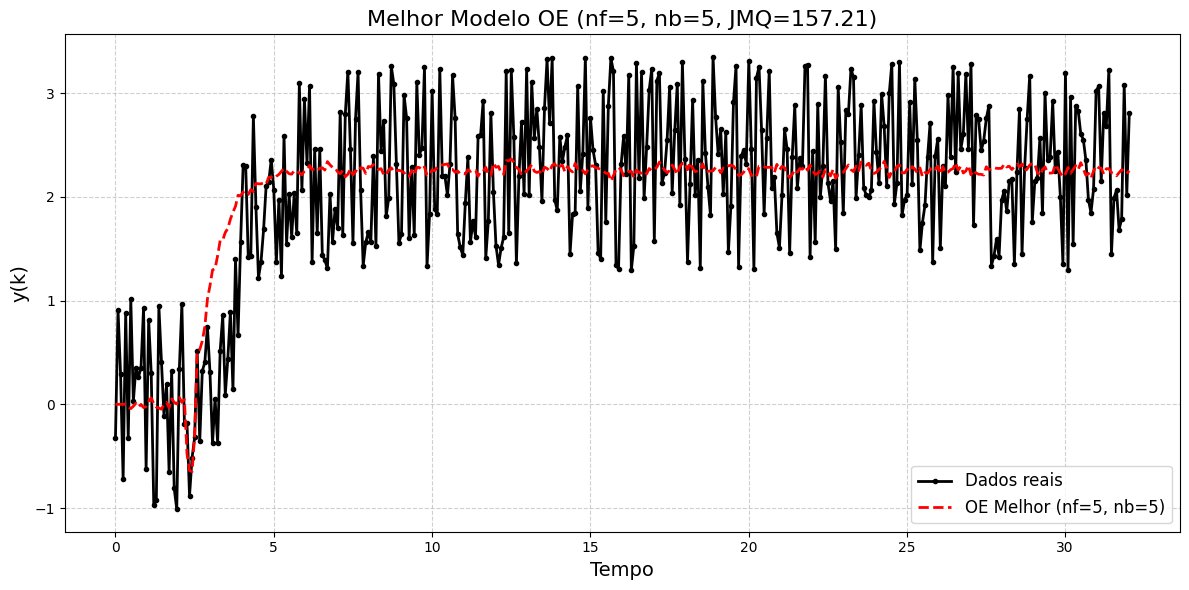

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

# Carregar os dados
data = loadmat('dados.mat')
Z = data['Z']

# Extrair tempo, entrada (u) e saída (y)
t = Z[:, 0]  # Coluna 0 é o tempo
u = Z[:, 1]  # Coluna 1 é a entrada
y = Z[:, 2]  # Coluna 2 é a saída

# Configurações do modelo OE
max_nf = 5  # Ordem máxima de F(q)
max_nb = 5  # Ordem máxima de B(q)
nk = 1  # Atraso inicial

# Inicializar matrizes de erro e função de custo
eoe = np.zeros((max_nf, max_nb, len(y)))
JMQoe = np.zeros((max_nf, max_nb))

# Variáveis para armazenar o melhor modelo
best_nf = None
best_nb = None
best_theta = None
best_yoe = None
best_JMQ = float('inf')

# Função auxiliar para o modelo OE
def oe_model(y, u, nf, nb, nk):
    """Estima os coeficientes de um modelo Output Error e retorna y_hat e coeficientes."""
    n = len(y)
    max_delay = max(nf, nb + nk - 1)
    Phi = []
    for i in range(max_delay, n):
        row = []
        # Termos autoregressivos da saída y (F(q))
        row.extend(-y[i - j - 1] for j in range(nf))
        # Termos regressivos da entrada u (B(q))
        row.extend(u[i - j - nk] for j in range(nb))
        Phi.append(row)
    Phi = np.array(Phi)
    y_target = y[max_delay:]

    # Estimativa dos parâmetros via mínimos quadrados
    theta, _, _, _ = lstsq(Phi, y_target)

    # Recriar a saída estimada
    y_hat = np.zeros(n)
    for i in range(max_delay, n):
        for j in range(nf):
            y_hat[i] -= theta[j] * y_hat[i - j - 1]  # Termos de F(q)
        for j in range(nb):
            y_hat[i] += theta[nf + j] * u[i - j - nk]  # Termos de B(q)
    return y_hat, theta

# Loop para varrer valores de nf e nb
for nf in range(1, max_nf + 1):
    for nb in range(1, nf + 1):  # Limitar nb <= nf para consistência
        yoe, theta = oe_model(y, u, nf, nb, nk)
        JMQ = np.sum((y - yoe) ** 2)
        JMQoe[nf - 1, nb - 1] = JMQ

        # Verificar se este é o melhor modelo
        if JMQ < best_JMQ:
            best_nf = nf
            best_nb = nb
            best_theta = theta
            best_yoe = yoe
            best_JMQ = JMQ

# Resultados do melhor modelo
print(f"Melhor modelo OE: nf={best_nf}, nb={best_nb}, JMQ={best_JMQ:.4f}")

# Plot do melhor modelo
plt.figure(figsize=(12, 6))
plt.plot(t, y, 'k.-', linewidth=2, markersize=6, label='Dados reais')
plt.plot(t, best_yoe, 'r--', linewidth=2, label=f'OE Melhor (nf={best_nf}, nb={best_nb})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('y(k)', fontsize=14)
plt.title(f'Melhor Modelo OE (nf={best_nf}, nb={best_nb}, JMQ={best_JMQ:.2f})', fontsize=16)
plt.tight_layout()
plt.savefig("assets/best_oe_model.png", dpi=300)
plt.show()


Melhor modelo BJ: nf=5, nb=5, JMQ=150.0744


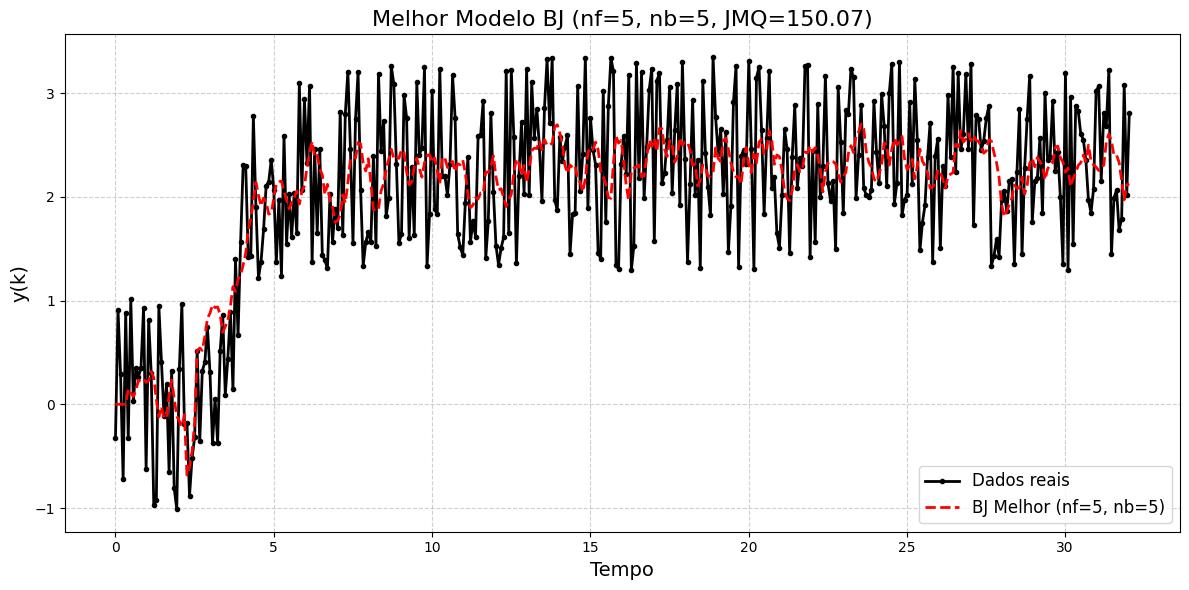

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

# Carregar os dados
data = loadmat('dados.mat')
Z = data['Z']

# Extrair tempo, entrada (u) e saída (y)
t = Z[:, 0]  # Coluna 0 é o tempo
u = Z[:, 1]  # Coluna 1 é a entrada
y = Z[:, 2]  # Coluna 2 é a saída

# Configurações do modelo BJ
max_nf = 5  # Ordem máxima de F(q)
max_nb = 5  # Ordem máxima de B(q)
nk = 1  # Atraso
nc = 1  # Ordem de C(q)
nd = 1  # Ordem de D(q)

# Inicializar matriz de erro e função de custo
ebj = np.zeros((max_nf, max_nb, len(y)))
JMQbj = np.zeros((max_nf, max_nb))

# Função auxiliar para o modelo BJ
def bj_model(y, u, nf, nb, nk):
    """Estima os coeficientes de um modelo Box-Jenkins e retorna y_hat e coeficientes."""
    # Construir matriz Phi
    n = len(y)
    max_delay = max(nf, nb + nk - 1)
    Phi = []
    for i in range(max_delay, n):
        row = []
        # Termos de F(q) (autoregressivos da saída)
        row.extend(-y[i - j - 1] for j in range(nf))
        # Termos de B(q) (regressivos da entrada)
        row.extend(u[i - j - nk] for j in range(nb))
        Phi.append(row)
    Phi = np.array(Phi)
    y_target = y[max_delay:]

    # Estimativa dos parâmetros via mínimos quadrados
    theta, _, _, _ = lstsq(Phi, y_target)

    # Recriar a saída estimada
    y_hat = np.zeros(n)
    for i in range(max_delay, n):
        y_hat[i] = np.dot(Phi[i - max_delay], theta)
    return y_hat, theta

# Loop para varrer valores de nf e nb
best_nf, best_nb = 0, 0
best_JMQ = float('inf')
best_ybj = None

for nf in range(1, max_nf + 1):
    for nb in range(1, nf + 1):  # Limitar nb <= nf para consistência
        ybj, _ = bj_model(y, u, nf, nb, nk)
        JMQ = np.sum((y - ybj) ** 2)
        JMQbj[nf - 1, nb - 1] = JMQ

        # Verificar se este é o melhor modelo
        if JMQ < best_JMQ:
            best_nf = nf
            best_nb = nb
            best_ybj = ybj
            best_JMQ = JMQ

# Resultados do melhor modelo
print(f"Melhor modelo BJ: nf={best_nf}, nb={best_nb}, JMQ={best_JMQ:.4f}")

# Plot do melhor modelo
plt.figure(figsize=(12, 6))
plt.plot(t, y, 'k.-', linewidth=2, markersize=6, label='Dados reais')
plt.plot(t, best_ybj, 'r--', linewidth=2, label=f'BJ Melhor (nf={best_nf}, nb={best_nb})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('y(k)', fontsize=14)
plt.title(f'Melhor Modelo BJ (nf={best_nf}, nb={best_nb}, JMQ={best_JMQ:.2f})', fontsize=16)
plt.tight_layout()
plt.savefig("assets/best_bj_model.png", dpi=300)
plt.show()

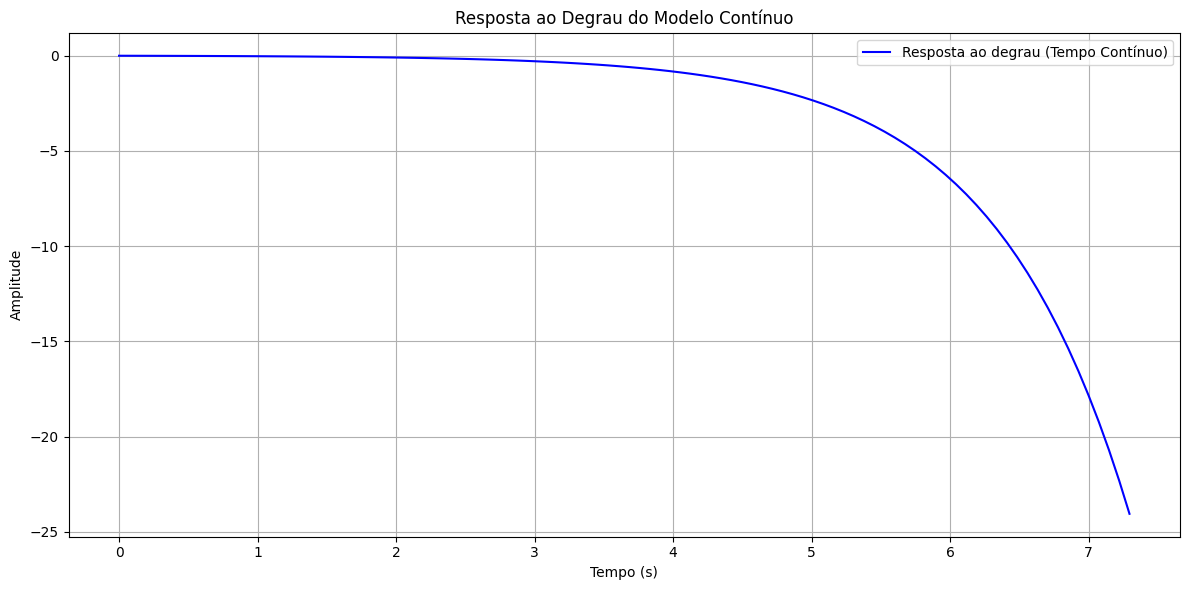

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import lstsq
from scipy.signal import bilinear, TransferFunction, step

# Carregar os dados
data = loadmat('dados.mat')  # Substitua pelo caminho correto
Z = data['Z']

# Extrair tempo, entrada (u) e saída (y)
t = Z[:, 0]  # Coluna 0 é o tempo
u = Z[:, 1]  # Coluna 1 é a entrada
y = Z[:, 2]  # Coluna 2 é a saída

# Melhor modelo ARX encontrado
best_na, best_nb, nk = 5, 5, 1  # Incluindo tempo morto nk

# Função auxiliar: Modelo ARX
def arx_model(y, u, na, nb, nk):
    """ Estima os coeficientes de um modelo ARX """
    n = len(y)
    max_delay = max(na, nb + nk - 1)
    Phi = []
    for i in range(max_delay, n):
        row = []
        row.extend(-y[i - j - 1] for j in range(na))  # Termos autoregressivos
        row.extend(u[i - j - nk] for j in range(nb))  # Termos regressivos
        Phi.append(row)
    Phi = np.array(Phi)
    y_target = y[max_delay:]
    theta, _, _, _ = lstsq(Phi, y_target)
    y_hat = np.zeros(n)
    y_hat[:max_delay] = y[:max_delay]
    for i in range(max_delay, n):
        y_hat[i] = np.dot(Phi[i - max_delay], theta)
    return y_hat, theta

# Obter o modelo ARX
_, theta_arx = arx_model(y, u, best_na, best_nb, nk)

# Função para criar a função de transferência contínua removendo tempo morto
def arx_to_tf_no_deadtime(theta, na, nb, dt, nk):
    """ Converte coeficientes ARX em função de transferência contínua, removendo tempo morto """
    a = [1] + list(theta[:na])  # Denominador
    b = [0] * nk + list(theta[na:])  # Numerador ajustado, tempo morto removido

    # Transformação bilinear (Tustin) para tempo contínuo
    b_ct, a_ct = bilinear(b, a, fs=1/dt)
    system_continuous = TransferFunction(b_ct, a_ct)

    return system_continuous

# Definir intervalo de amostragem
dt = t[1] - t[0]

# Converter modelo para tempo contínuo sem tempo morto
system_ct = arx_to_tf_no_deadtime(theta_arx, best_na, best_nb, dt, nk)

# Gerar resposta ao degrau
time_ct, response_ct = step(system_ct)

# Plotar a resposta ao degrau
plt.figure(figsize=(12, 6))
plt.plot(time_ct, response_ct, 'b-', label='Resposta ao degrau (Tempo Contínuo, Sem Tempo Morto)')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Resposta ao Degrau do Modelo Contínuo (Sem Tempo Morto)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
